# ECE521 Assignment 1: k Nearest Neighbours (k-NN)
## Younghoo Cho, Deng Pan, Keon Young Park


#### Part 1
#### Euclidean distance function [4 points]

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def dist(X,Z):
    # X is N1 x D, X_new is N1 x 1 x D
    X_new = tf.expand_dims(X, 1)
    # Z is N2 x D, Z_new is 1 x N2 x D
    Z_new = tf.expand_dims(Z, 0)
    # The subtraction broadcasts both matrices, such that they're both N1 x N2 x D
    return tf.reduce_sum((X_new - Z_new) ** 2, 2)



### Part 2 
####  Making Predictions for Regression [6 points]
#### 1. Choosing the nearest neighbours [2 pt.]


In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


def loadData():
    np.random.seed(521)
    Data = np.linspace(1.0 , 10.0 , num =100) [:, np. newaxis]
    Target = np.sin( Data ) + 0.1 * np.power( Data , 2) + 0.5 * np.random.randn(100 , 1)
    randIdx = np.arange(100)
    np.random.shuffle(randIdx)
    trainData, trainTarget = Data[randIdx[:80]], Target[randIdx[:80]]
    validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
    testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]
    return trainData, trainTarget, validData, validTarget, testData, testTarget#generates the data provided on assignment 1 handout

def dist(X,Z):
    X_new = tf.expand_dims(X, 1) # X is N1 x D, X_new is N1 x 1 x D
    Z_new = tf.expand_dims(Z, 0) # Z is N2 x D, Z_new is 1 x N2 x D
    return tf.reduce_sum((X_new - Z_new) ** 2, 2) # The subtraction broadcasts both matrices, such that they're both N1 x N2 x D

def knn_point(D,Z,test_data_pnt,k): # test_data_pnt is an element of Z
    col = tf.where(tf.equal(Z, test_data_pnt))[0,0] # acquires the index of test_data_pnt in Z
    dist_vec = -1*D[:,col] # extract the relevant distance column corresponding to that point
    temp = tf.one_hot(tf.nn.top_k(dist_vec,k)[1], tf.size(dist_vec)) # apply one_hot encoding to nn.top_k return value
    return tf.reduce_sum(temp,0)/k # returns responsibility vector for test_data_pnt


#### 2. Prediction [4 pt.]
#### 2.1 MSE Loss

In [15]:
def loadData():
    np.random.seed(521)
    Data = np.linspace(1.0 , 10.0 , num =100) [:, np. newaxis]
    Target = np.sin( Data ) + 0.1 * np.power( Data , 2) + 0.5 * np.random.randn(100 , 1)
    randIdx = np.arange(100)
    np.random.shuffle(randIdx)
    trainData, trainTarget = Data[randIdx[:80]], Target[randIdx[:80]]
    validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
    testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]
    return trainData, trainTarget, validData, validTarget, testData, testTarget#generates the data provided on assignment 1 handout

def dist(X,Z):
    X_new = tf.expand_dims(X, 1) # X is N1 x D, X_new is N1 x 1 x D
    Z_new = tf.expand_dims(Z, 0) # Z is N2 x D, Z_new is 1 x N2 x D
    return tf.reduce_sum((X_new - Z_new) ** 2, 2) # The subtraction broadcasts both matrices, such that they're both N1 x N2 x D

def knn_point(D,Z,test_data_pnt,k): # test_data_pnt is an element of Z
    col = tf.where(tf.equal(Z, test_data_pnt))[0,0] # acquires the index of test_data_pnt in Z
    dist_vec = -1*D[:,col] # extract the relevant distance column corresponding to that point
    temp = tf.one_hot(tf.nn.top_k(dist_vec,k)[1], tf.size(dist_vec)) # apply one_hot encoding to nn.top_k return value
    return tf.reduce_sum(temp,0)/k # returns responsibility vector for test_data_pnt

def knn_rstar(dist_vec, k):
    dist_vec = tf.transpose(dist_vec)# Transpose to get (distance for one test point) in the last dimension
    val, ind = tf.nn.top_k(-dist_vec, k)# Negate to get closest k neighbours, not farthest
    col = tf.shape(dist_vec)[1] # Get total number of training points to determine one_hot size
    val_r = tf.one_hot(ind, col) # Encode one-hot vector indicating closest k neighbours per test point and locate the closest sample
    val_rstar = tf.reduce_sum(val_r, 1) / k# Reduce k neighbours into one single row for each test point
    return tf.transpose(val_rstar)# Transpose back, get a matrix with size: (num of training points) x (num of test points)

def prediction(X_train, Y_train, X_set, k_val):
    dist_vec = knn_rstar(dist(X_train, X_set), k_val)#  Acquire responsibility vectors for each point in X_Set w.r.t X_train
    dist_vec = tf.cast(dist_vec, tf.float64)# Cast in float64 for better accuracy in predictions
    Y_train = tf.transpose(Y_train)# Compute transpose to prepare for vector-matrix multiplication
    Y_pred = tf.matmul(Y_train, dist_vec) # Computes the predicted dataset for X_set
    return Y_pred # Returns a row vector Y_pred with dimension: 1 x length(X_set)

def MSE_fcn(Y_pred, Y_set):
    Y_diff = Y_pred - tf.transpose(Y_set)
    MSE = (1/(2*tf.size(Y_set)))*tf.matmul(Y_diff, tf.transpose(Y_diff))
    return MSE

trainData, trainTarget, validData, validTarget, testData, testTarget = loadData()
k_list = [1,3,5,50]

MSE_training = []
MSE_valid = []
MSE_test = []

plotData = np.linspace(0.0, 11.0, num = 1000) [:, np. newaxis]
Y_pred_set = []

sess = tf.InteractiveSession()

for i in range(0, len(k_list)):
    MSE = sess.run(MSE_fcn(prediction(trainData, trainTarget, trainData, k_list[i]), trainTarget))
    MSE_training.append(MSE[0,0])

    MSE = sess.run(MSE_fcn(prediction(trainData, trainTarget, validData, k_list[i]), validTarget))
    MSE_valid.append(MSE[0,0])

    MSE = sess.run(MSE_fcn(prediction(trainData, trainTarget, testData, k_list[i]), testTarget))
    MSE_test.append(MSE[0,0])

print(MSE_training)
print(MSE_valid)
print(MSE_test)


[0.0, 0.10646488943195342, 0.1210685023615439, 1.2459853964924481]
[0.27154966972152689, 0.32437628398600493, 0.31669897837510286, 1.2287016697580737]
[0.13943234651568068, 0.15879689754963655, 0.18509598110335512, 0.70263160201298291]


#### 2.2 Prediction Function Plot

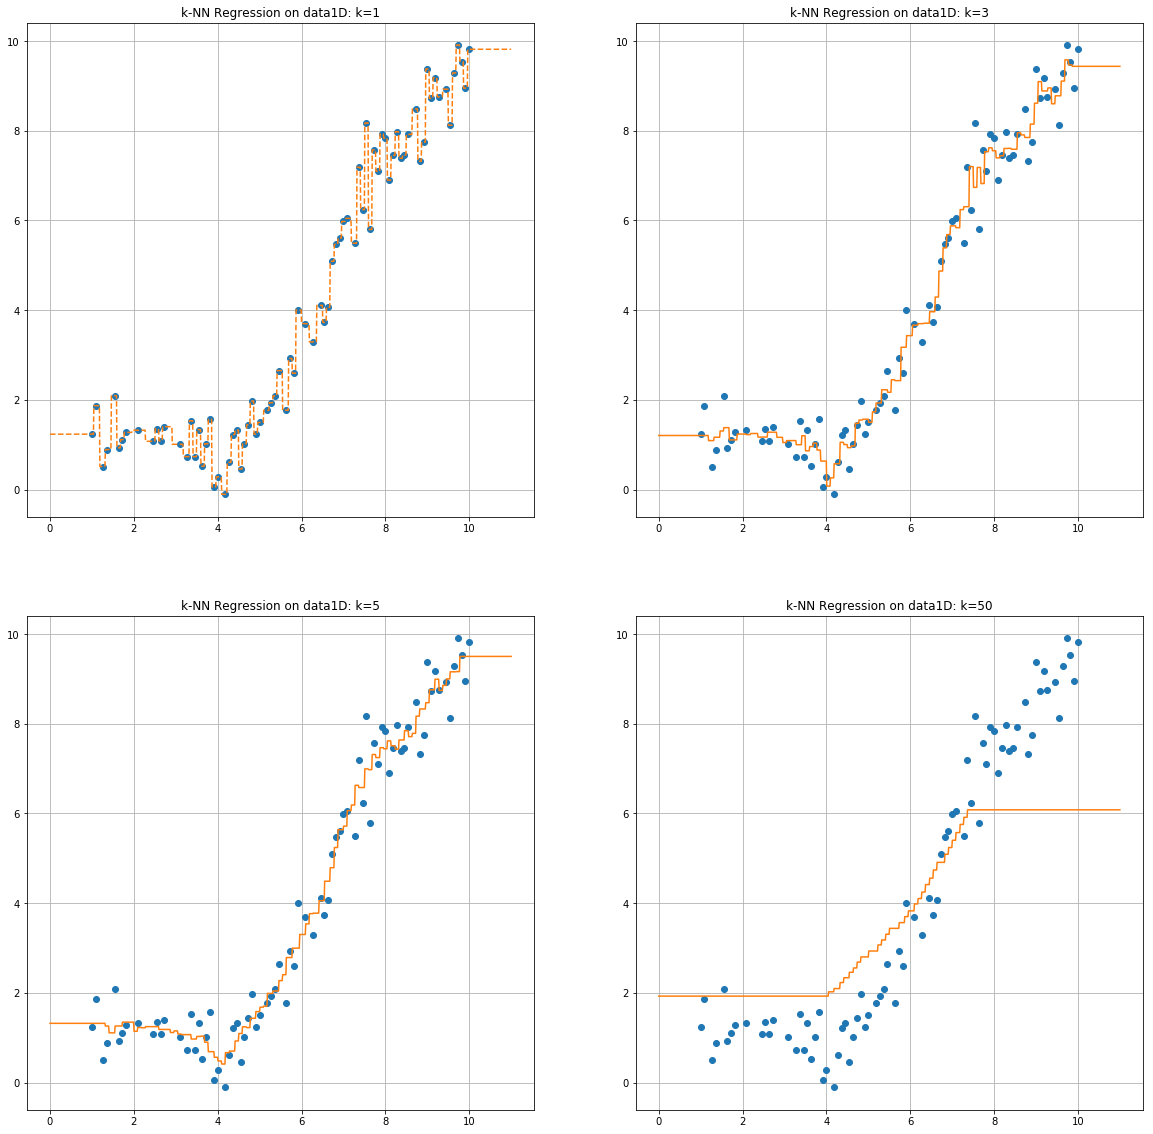

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plotData = np.linspace(0.0, 11.0, num = 1000) [:, np. newaxis]

for i in range(0, len(k_list)):
    Y_pred = sess.run(tf.transpose(prediction(trainData, trainTarget, plotData, k_list[i])))
    Y_pred_set.append(Y_pred)

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.plot(trainData,trainTarget,'o',plotData,Y_pred_set[0],'--')
plt.title('k-NN Regression on data1D: k=1')
plt.grid(True)

plt.subplot(222)
plt.plot(trainData,trainTarget,'o',plotData,Y_pred_set[1],'-')
plt.title('k-NN Regression on data1D: k=3')
plt.grid(True)

plt.subplot(223)
plt.plot(trainData,trainTarget,'o',plotData,Y_pred_set[2],'-')
plt.title('k-NN Regression on data1D: k=5')
plt.grid(True)

plt.subplot(224)
plt.plot(trainData,trainTarget,'o',plotData,Y_pred_set[3],'-')
plt.title('k-NN Regression on data1D: k=50')
plt.grid(True)
plt.show()

### Part 3
#### Making Predictions for Classification [10 points]
#### 1. Predicting class label [4 pt.]

In [20]:
# coding: utf-8

# # A1 Part 3 - kNN Classification - Face Recognition
# ### Report the recognition accuracy for face recognition using k-NN for different values of k over the validation dataset. 
# ### Use k = {1, 5, 10, 25, 50, 100, 200}.


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def data_segmentation(data_path, target_path, task):
# task = 0 >> select the name ID targets for face recognition task
# task = 1 >> select the gender ID targets for gender recognition task data = np.load(data_path)/255
    data = np.load(data_path)/255
    data = np.reshape(data, [-1, 32*32])

    target = np.load(target_path)
    np.random.seed(45689)

    rnd_idx = np.arange(np.shape(data)[0])
    np.random.shuffle(rnd_idx)
    trBatch = int(0.8*len(rnd_idx))
    validBatch = int(0.1*len(rnd_idx))
    trainData, validData, testData = data[rnd_idx[1:trBatch],:],    data[rnd_idx[trBatch+1:trBatch + validBatch],:],                                       data[rnd_idx[trBatch + validBatch+1:-1],:]
    trainTarget, validTarget, testTarget = target[rnd_idx[1:trBatch], task], target[rnd_idx[trBatch+1:trBatch + validBatch], task],                                  target[rnd_idx[trBatch + validBatch + 1:-1], task]
        
    return trainData, validData, testData, trainTarget, validTarget, testTarget


trainData, validData, testData, trainTarget, validTarget, testTarget = data_segmentation("data.npy", "target.npy", 1)

def dist(X,Z):
    # X is N1 x D, X_new is N1 x 1 x D
    X_new = tf.expand_dims(X, 1)
    # Z is N2 x D, Z_new is 1 x N2 x D
    Z_new = tf.expand_dims(Z, 0)
    # The subtraction broadcasts both matrices, such that they're both N1 x N2 x D
    return tf.reduce_sum((X_new - Z_new) ** 2, 2)

def predict(trainData, testData, trainTarget, k):
    prediction = []
    dist_vec = tf.transpose(dist(trainData,testData))
    val, ind = tf.nn.top_k(-dist_vec, k)
    classfs = tf.gather(trainTarget, ind)
    for i in range(len(tf.unstack(classfs))):
        val, idx, cnt = tf.unique_with_counts(classfs[i])
        majority_vote_idx = tf.argmax(cnt)
        majority_vote = tf.gather(val, majority_vote_idx)
        prediction.append(majority_vote)
    return prediction


#### 2. Face recognition using k-NN [4 pt.]

In [24]:
def get_kNN(trainData, testData, trainTarget, k):
    dist_vec = tf.transpose(dist(trainData, testData))
    val, ind = tf.nn.top_k(-dist_vec, k)
    return tf.gather(trainData, ind)

def get_kNN_distances(trainData, testData, trainTarget, k):
    dist_vec = tf.transpose(dist(trainData, testData))
    val, ind = tf.nn.top_k(-dist_vec, k)
    return val

# ----------- Accuracy test-------------- #
def accu_test(predict, target): 
    accuracy = tf.count_nonzero(predict - target) / tf.cast(tf.shape(target), tf.int64)
    final = 1 - accuracy
    return final

trainData, validData, testData, trainTarget, validTarget, testTarget = data_segmentation("data.npy", "target.npy", 0)
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

# sess.run(tf.shape(trainData))

k_val = [1,5,10,25,50,100,200]
for k in k_val:
    sess.run(init)
    v_pred = sess.run(predict(trainData, validData, trainTarget, k))
    print("The accuracy of prediction with k value = {0}, is {1}.".format(k,sess.run(accu_test(v_pred, validTarget))))

print()
k = 1
sess.run(init)
v_pred = sess.run(predict(trainData, testData, trainTarget, k))
print("The accuracy of prediction with k value = {0}, is {1}.".format(k,sess.run(accu_test(v_pred, testTarget))))




The accuracy of prediction with k value = 1, is [ 0.66304348].
The accuracy of prediction with k value = 5, is [ 0.60869565].
The accuracy of prediction with k value = 10, is [ 0.57608696].
The accuracy of prediction with k value = 25, is [ 0.59782609].
The accuracy of prediction with k value = 50, is [ 0.57608696].
The accuracy of prediction with k value = 100, is [ 0.47826087].
The accuracy of prediction with k value = 200, is [ 0.31521739].

The accuracy of prediction with k value = 1, is [ 0.70967742].


#### 2.1 Mispredicted Image

In [47]:
# Find a test case where prediction is wrong
k = 10
v_pred = sess.run(predict(trainData, testData, trainTarget, k))
mispred_idx = 0
# sess.run(tf.shape(v_pred))
for i in range(len(v_pred)):
    if (v_pred[i] != testTarget[i]):
        print("Wrong prediction!")
        mispred_idx = i
        image = np.array(testData[i])
#         kk = testData[i]
#         break
        image = image.reshape(32, 32)
        plt.imshow(image, cmap="gray")
        plt.show()
        break

# print(sess.run(tf.shape(v_pred)))

# print(sess.run(tf.shape(testTarget)))
# sess.run(tf.shape(kk))
# sess.run(tf.shape(testData))



Wrong prediction!


array([  93, 1024], dtype=int32)

#### 2.2 k-neighbours' images

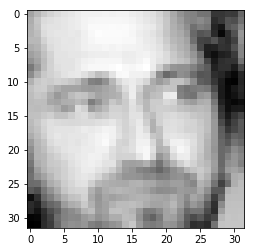

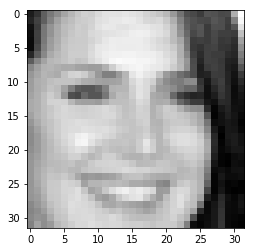

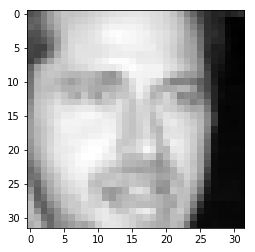

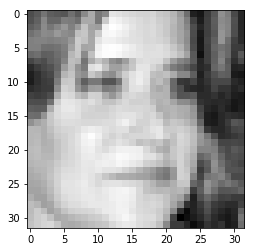

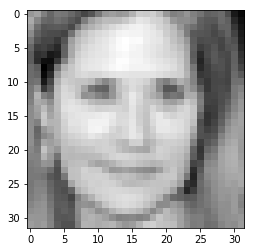

[-22.75093996 -29.30236807 -31.47621287 -32.55852563 -33.68658308
 -34.48203445 -35.09090499 -35.78252335 -36.33632821 -37.00175565]
[-19.32645459 -24.5354742  -26.81942578 -28.68959259 -29.97041833
 -30.71246171 -31.42030534 -32.18616165 -32.82705337 -33.43294936]


In [8]:
# k-neighbours' images
k_images = sess.run(get_kNN(trainData, testData, trainTarget, k))
# Get k-nn images to mispredicted image above
k_mispred_nn_images = k_images[mispred_idx]
# Go across each image in k-nn image set
for i in range(len(k_mispred_nn_images)):
    image = np.array(k_mispred_nn_images[i])
    image = image.reshape(32,32)
    plt.imshow(image, cmap="gray")
    plt.show()

# Find average pairwise distances
incorrect_pred_distances = []
correct_pred_distances = []
k_image_distances = sess.run(get_kNN_distances(trainData, testData, trainTarget, k))
for test_image_idx in range(len(k_image_distances)):
    if (v_pred[test_image_idx] != testTarget[test_image_idx]):
        incorrect_pred_distances.append(k_image_distances[test_image_idx])
    else:
        correct_pred_distances.append(k_image_distances[test_image_idx])
# Average
incorrect_pred_avg_dist = np.sum(incorrect_pred_distances, axis=0) / len(incorrect_pred_distances)
print(incorrect_pred_avg_dist)
correct_pred_avg_dist = np.sum(correct_pred_distances, axis=0) / len(correct_pred_distances)
print(correct_pred_avg_dist)


#### 3. Gender recognition using k-NN [2 pt.]

In [46]:
def get_kNN(trainData, testData, trainTarget, k):
    dist_vec = tf.transpose(dist(trainData, testData))
    val, ind = tf.nn.top_k(-dist_vec, k)
    return tf.gather(trainData, ind)

def get_kNN_distances(trainData, testData, trainTarget, k):
    dist_vec = tf.transpose(dist(trainData, testData))
    val, ind = tf.nn.top_k(-dist_vec, k)
    return val

# ----------- Accuracy test-------------- #
def accu_test(predict, target): 
    accuracy = tf.count_nonzero(predict - target) / tf.cast(tf.shape(target), tf.int64)
    final = 1 - accuracy
    return final

trainData, validData, testData, trainTarget, validTarget, testTarget = data_segmentation("data.npy", "target.npy", 1)
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

k_val = [1,5,10,25,50,100,200]
for k in k_val:
    sess.run(init)
    v_pred = sess.run(predict(trainData, validData, trainTarget, k))
    print("The accuracy of prediction with k value = {0}, is {1}.".format(k,sess.run(accu_test(v_pred, validTarget))))

print()
k = 1
sess.run(init)
v_pred = sess.run(predict(trainData, testData, trainTarget, k))
print("The accuracy of prediction with k value = {0}, is {1}.".format(k,sess.run(accu_test(v_pred, testTarget))))

# sess.run(tf.shape(get_kNN(trainData, testData, trainTarget, 10)))


array([  93,   10, 1024], dtype=int32)

#### 3.1 Mispredicted Image


Wrong prediction!


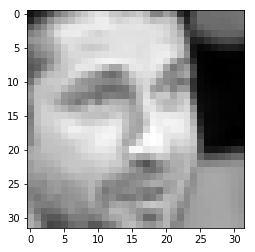

1


In [50]:
# Find a test case where prediction is wrong
k = 10
v_pred = sess.run(predict(trainData, testData, trainTarget, k))
mispred_idx = 0
for i in range(len(v_pred)):
    if (v_pred[i] != testTarget[i]):
        print("Wrong prediction!")
        mispred_idx = i
        image = np.array(testData[i])
        image = image.reshape(32, 32)
        plt.imshow(image, cmap="gray")
        plt.show()
        break

print(mispred_idx)

#### 3.2 k-neighbours' images

In [54]:
# k-neighbours' images
k_images = sess.run(get_kNN(trainData, testData, trainTarget, k))
# Get k-nn images to mispredicted image above
k_mispred_nn_images = k_images[mispred_idx]
k_mispred_nn_images_1 = k_images[3]
# Go across each image in k-nn image set

# for i in range(len(k_mispred_nn_images)):
#     image = np.array(k_mispred_nn_images[i])
#     image = image.reshape(32,32)
#     plt.imshow(image, cmap="gray")
#     plt.show()

print(sess.run(tf.shape(k_images)))
print(sess.run(tf.shape(k_mispred_nn_images)))
print(sess.run(tf.shape(k_mispred_nn_images_1)))
# # Find average pairwise distances
# incorrect_pred_distances = []
# correct_pred_distances = []
# k_image_distances = sess.run(get_kNN_distances(trainData, testData, trainTarget, k))
# for test_image_idx in range(len(k_image_distances)):
#     if (v_pred[test_image_idx] != testTarget[test_image_idx]):
#         incorrect_pred_distances.append(k_image_distances[test_image_idx])
#     else:
#         correct_pred_distances.append(k_image_distances[test_image_idx])
# # Average
# incorrect_pred_avg_dist = np.sum(incorrect_pred_distances, axis=0) / len(incorrect_pred_distances)
# print(incorrect_pred_avg_dist)
# correct_pred_avg_dist = np.sum(correct_pred_distances, axis=0) / len(correct_pred_distances)
# print(correct_pred_avg_dist)

[  93   10 1024]
[  10 1024]
[  10 1024]


In [67]:
a = tf.constant([[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]]])

In [68]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)


In [69]:
sess.run(tf.shape(a))

array([5, 3, 3], dtype=int32)

In [72]:
sess.run(a[1])
sess.run(a)

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=int32)

In [64]:
sess.run(tf.shape(a[1]))

array([3, 3], dtype=int32)